<a href="https://colab.research.google.com/github/Nhattysha/Ethiopian-Language-Survey/blob/main/LH_3_IPYnother_copy_of_https_github_com_shawnhan108_Attention_LSTMs_blob_master_English_20to_20Italian_20Machine_20Translation_20with_20BiLSTM_20and_20Attention_ipynb_checkpoints_English_20to_20Mandarin_20Machine_20Translation_20with_20BiLSTM_20and_20A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os, sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
BATCHSIZE = 128
EPOCH = 35
LATENT_DIM = 500
LATENT_DIM_DECODER = LATENT_DIM
SAMPLES = 2000
MAX_WORD_NUM = SAMPLES
MAX_SEQ_LEN = 100
EMBEDDING = MAX_SEQ_LEN

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:



# Initialize lists to store processed data
eng = []
man = []
man_inputs = []

count = 0
SAMPLES = 20000  # Define the number of samples you want to process

# Open and preprocess the translation file
with open('/content/drive/My Drive/mergeds.txt', 'r') as file:
    for line in file:
        # Split the line into parts by tab
        parts = line.rstrip().split('\t')
        if len(parts) < 2:
            continue  # Skip lines that don't contain at least two tab-separated values

        count += 1
        if count > SAMPLES:
            break

        # Extract English and translated sentences
        e = parts[0]
        m = parts[1]

        # Append to lists
        eng.append(e)
        man.append(m + ' <eos>')
        man_inputs.append('<sos> ' + m)

        if count % 2000 == 0:
            print('Sample Count: {}.'.format(count))

# Verify the contents of the lists
print("English sentences:", eng[:5])
print("Translated sentences with <eos>:", man[:5])
print("Translated sentences with <sos>:", man_inputs[:5])


Sample Count: 2000.
English sentences: ['Run.', 'Wait!', 'Listen.', 'I try.', 'I won!']
Translated sentences with <eos>: ['ውጥየነው <eos>', 'ሊምደነው <eos>', 'ሰዝ ወሹ <eos>', 'ሚኩሩን <eos>', 'ጣቑን <eos>']
Translated sentences with <sos>: ['<sos> ውጥየነው', '<sos> ሊምደነው', '<sos> ሰዝ ወሹ', '<sos> ሚኩሩን', '<sos> ጣቑን']


In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Initialize Tokenizer with defined maximum number of words
MAX_WORD_NUM = 1000
tok_in = Tokenizer(num_words=MAX_WORD_NUM)
tok_in.fit_on_texts(eng)
eng_seq = tok_in.texts_to_sequences(eng)
word2idx_in = tok_in.word_index
max_in_len = max(len(s) for s in eng_seq)
print("Number of input tokens: {}".format(len(word2idx_in)))
print("Maximum input sequence length: {}".format(max_in_len))

# tokenize output and generate idx map
tok_out = Tokenizer(num_words=MAX_WORD_NUM, filters='')
tok_out.fit_on_texts(man + man_inputs)
man_seq = tok_out.texts_to_sequences(man)
man_seq_inputs = tok_out.texts_to_sequences(man_inputs)
word2idx_out = tok_out.word_index
max_out_len = max(len(s) for s in man_seq)
out_word_num = len(word2idx_out) + 1

print("Number of output tokens: {}".format(len(word2idx_out)))
print("Maximum output sequence length: {}".format(max_out_len))

Number of input tokens: 3220
Maximum input sequence length: 62
Number of output tokens: 11321
Maximum output sequence length: 25


In [9]:
from keras.preprocessing.sequence import pad_sequences

eng_seq_padded = pad_sequences(eng_seq, maxlen=max_in_len)
man_seq_padded = pad_sequences(man_seq, maxlen=max_out_len, padding='post')
man_seq_inputs_padded = pad_sequences(man_seq_inputs, maxlen=max_out_len, padding='post')

In [10]:
import numpy as np

In [11]:
wordVec = {}

print('Loading wordVec')

# load in word vectors in a dict
with open('/content/drive/My Drive/glove.6B.100d.txt') as f:
    for line in f:
        data = line.split()
        word = data[0]
        vec = np.asarray(data[1:], dtype='float32')
        wordVec[word] = vec

print('Finished loading wordVec.')

Loading wordVec
Finished loading wordVec.


In [12]:
EMBEDDING = 100
wordNum = min(MAX_WORD_NUM, len(word2idx_in) + 1)
word_embedding = np.zeros((wordNum, EMBEDDING))

# create word embedding by fetching each word vector
for tok, idx in word2idx_in.items():
    if idx < MAX_WORD_NUM:
        word_vector = wordVec.get(tok)
        if word_vector is not None:
            word_embedding[idx] = word_vector

In [13]:
man_target_one_hot = np.zeros((len(eng), max_out_len, out_word_num), dtype='float32')

for idx, tokVec in enumerate(man_seq_padded):
    for tok_idx, tok in enumerate(tokVec):
        if (tok > 0):
            man_target_one_hot[idx, tok_idx, tok] = 1

In [14]:
from keras.layers import Embedding, Input, LSTM, GRU, Dense, Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
import keras.backend as K
from keras.models import Model

# Embedding
embedding = Embedding(wordNum, EMBEDDING, weights=[word_embedding], input_length=max_in_len)

# Encoder
LATENT_DIM = 256
input_layer_encoder = Input(shape=(max_in_len,))
embed_encoder = embedding(input_layer_encoder)
encoder = Bidirectional(LSTM(LATENT_DIM, return_sequences=True, dropout=0.2))
encoder_out = encoder(embed_encoder)

# Decoder input
input_layer_decoder = Input(shape=(max_out_len,))
embed_decoder = Embedding(out_word_num, EMBEDDING)
decoder_input = embed_decoder(input_layer_decoder)

# Decoder output, after attention
LATENT_DIM_DECODER = 256
decoder = LSTM(LATENT_DIM_DECODER, return_state=True)
dense_decode = Dense(out_word_num, activation='softmax')
s0 = Input(shape=(LATENT_DIM_DECODER,))
c0 = Input(shape=(LATENT_DIM_DECODER,))

In [15]:
# Dimension of x is N x T x D.
def softmax(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

# Some of the common layers for attention
repeat_attn = RepeatVector(max_in_len)
concat_attn = Concatenate(axis=-1)
dense1_attn = Dense(10, activation='tanh')  # over time dimension T
dense2_attn = Dense(1, activation=softmax)
dot_attn = Dot(axes=1)                      # over time dimension T

def iterAttn(h, prevOut):
    """
    h: encoder encoded hidden states at all time.
    prevOut: output at the previous time (word).
    An iteration of attention.
    """
    prevOutRepeat = repeat_attn(prevOut) # Tx, LATENT_DIM_DECODE
    total = concat_attn([h, prevOutRepeat]) # Tx, LATENT_DIM_DECODE + LATENT_DIM * 2
    d = dense1_attn(total)
    alphaLayer = dense2_attn(d)
    context = dot_attn([alphaLayer, h])

    return context

In [16]:
s = s0
c = c0

# Iterate attention Ty times
all_out = []
for t in range(max_out_len):
    # Get context vector with encoder and attention
    context = iterAttn(encoder_out, s)

    # For teacher forcing, get the previous word
    select_layer = Lambda(lambda x: x[:, t:t+1])
    prevWord = select_layer(decoder_input)

    # Concat context and previous word as decoder input
    concat2 = Concatenate(axis=2)
    decoder_in_concat = concat2([context, prevWord])

    # pass into decoder, inference output
    pred, s, c = decoder(decoder_in_concat, initial_state=[s, c])
    pred = dense_decode(pred)
    all_out.append(pred)

In [17]:
def stack(outputs):
    outputs = K.stack(outputs)
    return K.permute_dimensions(outputs, pattern=(1, 0, 2))

stack_layer = Lambda(stack)
all_out = stack_layer(all_out)

In [18]:
attnModel = Model(inputs=[input_layer_encoder, input_layer_decoder, s0, c0,],
                 outputs=all_out)

In [19]:
def myLoss(y_train, pred):
    mask = K.cast(y_train > 0, dtype='float32')
    val = mask * y_train * K.log(pred)
    return -K.sum(val) / K.sum(mask)

def acc(y_train, pred):
    targ = K.argmax(y_train, axis=-1)
    pred = K.argmax(pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')

    mask = K.cast(K.greater(targ, 0), dtype='float32') # filter out padding value 0.
    correctCount = K.sum(mask * correct)
    totalCount = K.sum(mask)
    return correctCount / totalCount

In [20]:
attnModel.compile(optimizer='adam', loss=myLoss, metrics=[acc])

# Define empty s0 and c0
init_s = np.zeros((len(eng_seq_padded), LATENT_DIM_DECODER))
init_c = np.zeros((len(eng_seq_padded), LATENT_DIM_DECODER))

# Assuming BATCHSIZE is 32
BATCHSIZE = 32
EPOCH = 10

# Training the model
history = attnModel.fit(
    x=[eng_seq_padded, man_seq_padded, init_s, init_c],
    y=man_target_one_hot,
    batch_size=BATCHSIZE,
    epochs=EPOCH,
    validation_split=0.22
)



Epoch 1/10
69/69 [==============================] - 207s 2s/step - loss: 6.5997 - acc: 0.1510 - val_loss: 6.3338 - val_acc: 0.1585
Epoch 2/10
69/69 [==============================] - 128s 2s/step - loss: 5.8914 - acc: 0.1537 - val_loss: 6.3042 - val_acc: 0.1585
Epoch 3/10
69/69 [==============================] - 129s 2s/step - loss: 5.8815 - acc: 0.1534 - val_loss: 6.3093 - val_acc: 0.1585
Epoch 4/10
69/69 [==============================] - 127s 2s/step - loss: 5.8767 - acc: 0.1535 - val_loss: 6.3109 - val_acc: 0.1585
Epoch 5/10
69/69 [==============================] - 134s 2s/step - loss: 5.8736 - acc: 0.1537 - val_loss: 6.3112 - val_acc: 0.1585
Epoch 6/10
69/69 [==============================] - 137s 2s/step - loss: 5.8701 - acc: 0.1540 - val_loss: 6.3440 - val_acc: 0.1585
Epoch 7/10
69/69 [==============================] - 131s 2s/step - loss: 5.8672 - acc: 0.1532 - val_loss: 6.3336 - val_acc: 0.1585
Epoch 8/10
69/69 [==============================] - 128s 2s/step - loss: 5.8652 - a

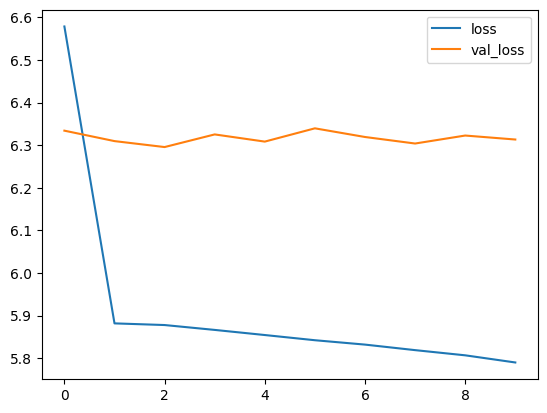

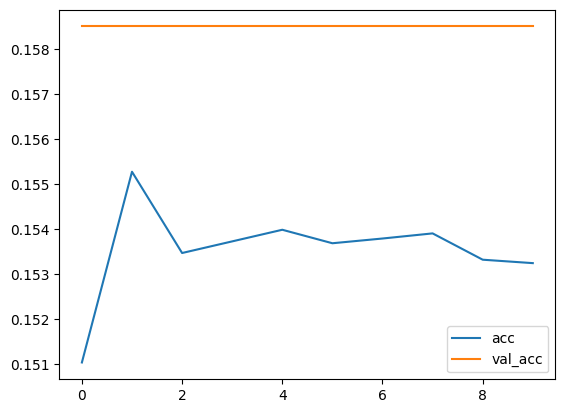

In [21]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [22]:
attnModel.save('attention_model_35_man.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
# Encoder
encoder_inf = Model(input_layer_encoder, encoder_out)
encoder_out_inf = Input(shape=(max_in_len, LATENT_DIM * 2,))

# Decoder
decoder_in_inf = Input(shape=(1,))
decoder_in_embed_inf = embed_decoder(decoder_in_inf)

# Context, concat without teacher forcing.
context_inf = iterAttn(encoder_out_inf, s0)
decoder_in_concat_inf = concat2([context_inf, decoder_in_embed_inf])

# Decoder inference
pred, s, c = decoder(decoder_in_concat_inf, initial_state=[s0, c0])
pred_out = dense_decode(pred)

# Define model
decoder_inf = Model(
    inputs=[decoder_in_inf, encoder_out_inf, s0, c0],
    outputs=[pred_out, s, c]
)

In [24]:
idx2word_in = {b:a for a, b in word2idx_in.items()}
idx2word_out = {b:a for a, b in word2idx_out.items()}

def inference(eng_seq):
    # Encode
    encoder_output = encoder_inf.predict(eng_seq)

    # Create output seq matrix
    target_output = np.zeros((1, 1))
    target_output[0, 0] = word2idx_out['<sos>']

    # init
    eos = word2idx_out['<eos>']
    s0 = np.zeros((1, LATENT_DIM_DECODER))
    c0 = np.zeros((1, LATENT_DIM_DECODER))

    output_seq = []
    s = s0
    c = c0
    for _ in range(max_out_len):
        # Decoder inference
        pred, s, c = decoder_inf.predict([target_output, encoder_output, s, c])

        # update output seq
        tok = np.argmax(pred.flatten())
        if tok == eos:
            break
        if tok > 0:
            word = idx2word_out[tok]
            output_seq.append(word)

        # Update decoder input
        target_output[0, 0] = tok

    sentence = ' '.join(output_seq)
    return sentence

In [25]:
for _ in range(20):
    i = np.random.choice(len(eng))
    eng_sen = eng_seq_padded[i:i+1]
    man_pred = inference(eng_sen)

    print('--------------------------------------')
    print('English: {}'.format(eng[i]))
    print('Prediction: {}'.format(man_pred))
    print('Ground truth: {}'.format(man[i]))

1/1 [==============================] - 1s 707ms/step
--------------------------------------
English: The Pharisees came and began to ask Jesus questions. They wanted to test him. So they asked him for a sign from heaven.
Prediction: 
Ground truth: ፈሪሳንድም እየሱስ ትጐ ተርጝ ተከራክርሽጥጘ ኪርምⶖ፤ ፊትንጠጘም በንጝ፦ «ሲመይስ ምልክት ቓሊሽ» ይጝ ዋቕር። <eos>
1/1 [==============================] - 0s 50ms/step
--------------------------------------
English: Jesus came from Galilee to the Jordan River. He wanted to be baptized by John.
Prediction: 
Ground truth: .ኣይንድ እየሱስ ይዃንስት ናኒዝ ጣምቅሽጠ ገሊለስ ዮርዳኖስ ትጐ ተሩ። <eos>
1/1 [==============================] - 0s 39ms/step
--------------------------------------
English: And the child grew and became strong. He was very wise. He was blessed by God’s grace.
Prediction: 
Ground truth: ኽፃንድም ሊግዛ ጣጝክራም ፊሩ፤ ጥቨቭኘም ኣቑ፤ እደረት ፃገድም ጝግል ዊኑ። <eos>
1/1 [==============================] - 0s 38ms/step
--------------------------------------
English: They were amazed at his teaching, because his wo

Conclusion
This project implements an encoder-decoder-based seq2seq model using BiLSTM and attention mechanism. It is observed that the model achieves an accuracy of 0.85 on validation data, although the translated sentences differ from the groundtruth to a considerable extent.